# EIT-CEM Forward Problem

In [1]:
#Fix your enviroment
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from codes.module1_mesh import *
from codes.module2_forward import *
from codes.module3_inverse import *
from codes.module4_auxiliar import *
%matplotlib inline

In [6]:
"Electrodes and Mesh"
ele_pos=electrodes_position(L=16, per_cober=0.5, rotate=0)
mesh_refined=MyMesh(r=1, n=20, n_in=80, n_out=60, electrodes_obj=ele_pos)
mesh_inverse=MyMesh(r=1, n=10, n_in=8, n_out=1, electrodes_obj=ele_pos)

#### Malhas

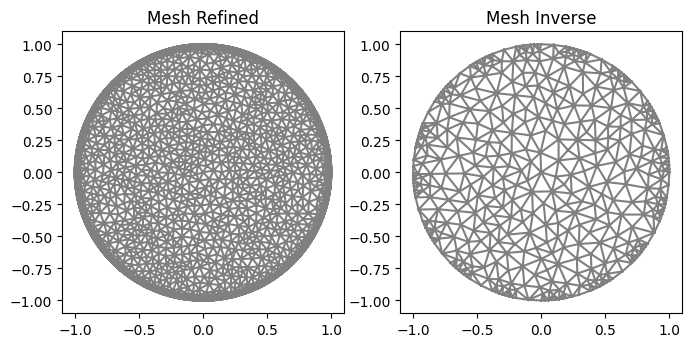

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_refined, title="Mesh Refined");
plt.subplot(1,2,2)
plot(mesh_inverse, title="Mesh Inverse");
plt.savefig("inverse/mesh.png", bbox_inches='tight', transparent=True)

## Problema Direto

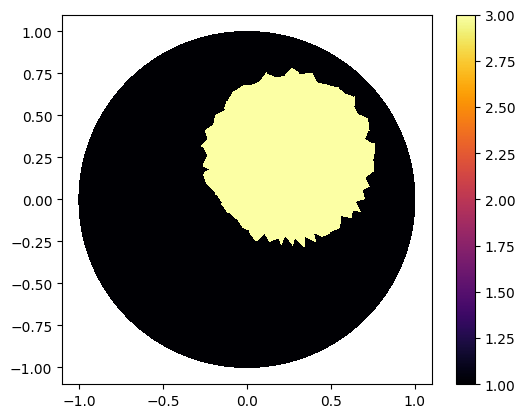

In [51]:
ValuesCells0=GammaCircle(mesh_refined,3.0,1.0,0.50, 0.25, 0.25);
Q = FunctionSpace(mesh_refined, "DG", 0) #Define Function space with basis Descontinuous Galerkin
gamma0 = Function(Q)
gamma0.vector()[:]=ValuesCells0          

"Plot"
plot_figure(gamma0, name="")
plt.savefig("inverse/gamma.png", bbox_inches='tight', transparent=True)

### Forward Problem

In [12]:
"Forward Problem"
VD=FiniteElement('CG',mesh_refined.ufl_cell(),1) #Lagrange pol. degree 1
L=16                                            #Electrodes number
l=15                                             #Measurements number.
z=np.ones(L)*0.025                              #Impedance
I_all=current_method(L,l, method=2, value=1)    #Current pattern

#Solver
ForwardObject=ForwardProblem(mesh_refined, z)
list_u0, list_U0 = ForwardObject.solve_forward(VD, I_all, gamma0)
list_U0 = ForwardObject.sol_asarray()

In [13]:
print(len(list_U0))

240


### Solver

### Plot Noise

In [14]:
"Getting noised solution"
noise_level=0.01 #0.5%
noise_type='uniform'
if noise_level>1E-10: list_U0_noised = ForwardObject.add_noise(noise_level, noise_type, seed=1)

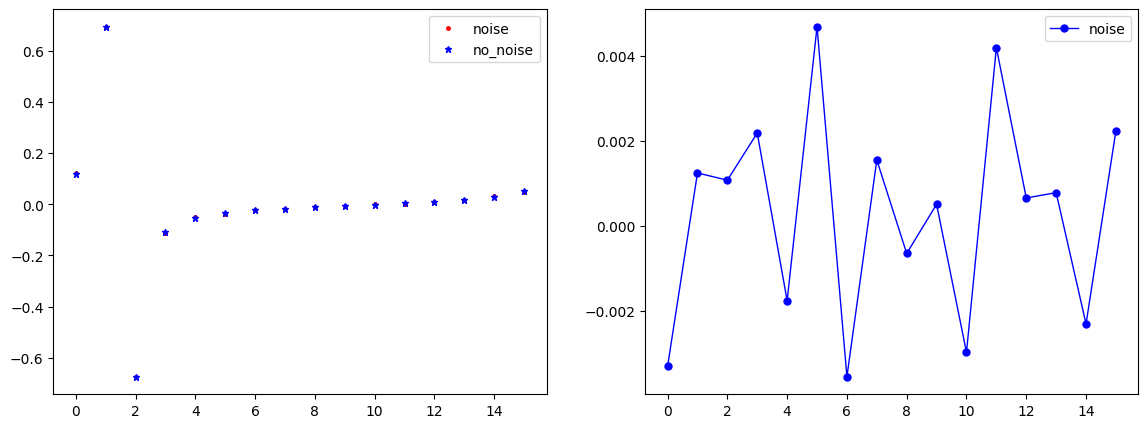

In [53]:
"Plot electrodes noise."
index=1 #Index in array

if noise_level>1E-5:
    vec_U0_noise=list_U0_noised[index*L:(index+1)*L]
    vec_U0=list_U0[index*L:(index+1)*L]
    x=range(len(vec_U0_noise))

    plt.figure(figsize=(14, 5),)
    plt.subplot(1,2,1)
    plt.plot(x, vec_U0_noise, linewidth=0,  marker='.', markersize=5, label="noise", color='red');
    plt.plot(x, vec_U0, linewidth=0,  marker='*', markersize=5, label="no_noise", color="blue");
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(x, vec_U0-vec_U0_noise, linewidth=1,  marker='.', markersize=10, label="noise", color="blue");
    plt.legend()
    
plt.savefig("inverse/plot_noise.png", bbox_inches='tight', transparent=True)

### Solver Parameters

In [34]:
"Object"
InverseObject=InverseProblem(mesh_inverse, list_U0_noised, I_all, z, select_pot_method=0)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=100, verbose=True)
InverseObject.set_NewtonParameters(mu_i=0.90, mumax=0.999, nu=0.99, R=1)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_InnerParameters(inner_method='ME', ME_reg=1E-4)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.95, LM_q=0.5)
#InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.95, Tik_q=0.1)

#First step
MyCellsgamma_k=np.ones(mesh_inverse.num_cells())*1.0
InverseObject.set_firstguess(MyCellsgamma_k)

"Noise Parameters"
tau=1.15
InverseObject.set_NoiseParameters(tau=tau, noise_level=noise_level)
print(f"Discrepance stop {tau*noise_level*100}% residue")

"Noise Parameters"
InverseObject.set_answer(gamma0, mesh_refined)
InverseObject.weight_value=True

Discrepance stop 1.15% residue


In [35]:
#Solver
InverseObject.solve_inverse()

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 57.801951165043896 Residual (%): 10.354350316437595 step: 0 Inner step: 0
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 55.79067 Residual (%): 9.345522 step: 1 Inner step: 36 mu_n: 0.9
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 53.852442 Residual (%): 8.438879 step: 2 Inner step: 35 mu_n: 0.9
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 51.950432 Residual (%): 7.604439 step: 3 Inner step: 35 mu_n: 0.8991
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 50.093908 Residual (%): 6.840494 step: 4 Inner step: 35 mu_n: 0.898201
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 48.282803 Residual (%): 6.145372 step: 5 Inner st

In [25]:
"Getting the result"
gamma_k=InverseObject.gamma_k
list_U=InverseObject.list_U

"Getting data_summary"
innerstep_vec=InverseObject.innerstep_vec
res_vec=InverseObject.res_vec
mun_vec=InverseObject.mun_vec
error_vec=InverseObject.error_vec

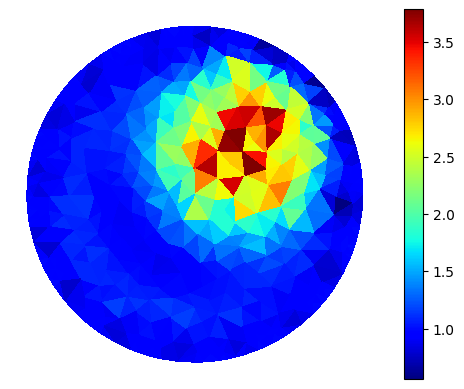

In [42]:
#Plot 2D
#Preparing Function
Q_DG=FunctionSpace(mesh_inverse, "DG", 0)
gamma_cell = Function(Q_DG)
gamma_cell.vector()[:]=gamma_k.vector()[:]          #Transform vector to function

#Plotting
plot_figure(gamma_cell, name="", map="jet");
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("inverse/gammares.png", bbox_inches='tight', transparent=True)

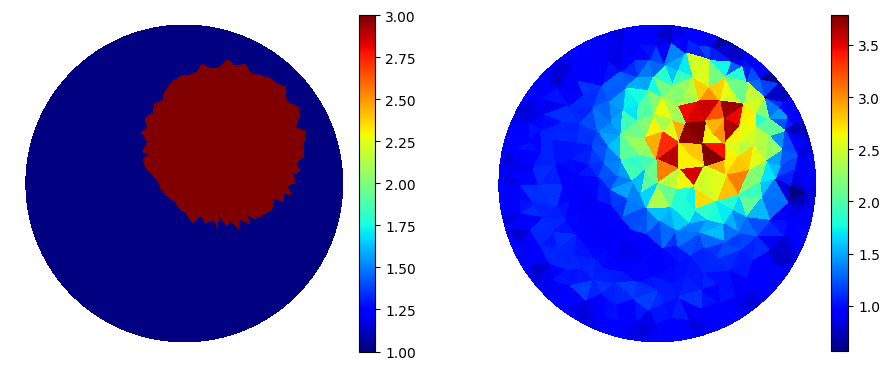

In [43]:
"Fancy plot"
cmap='jet'
fig=plt.figure(figsize=(9, 9))
plt.subplot(1,2,1);
p=plot(gamma0);
p.set_cmap(cmap)
plt.colorbar(p,fraction=0.046, pad=0.0);
plt.xticks([])
plt.yticks([])
plt.box(False)

plt.subplot(1,2,2);
p=plot(gamma_k);
p.set_cmap(cmap);
plt.colorbar(p,fraction=0.046, pad=0.0);
fig.tight_layout()
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("inverse/gammaresfancy.png", bbox_inches='tight', transparent=True)


#### Potencial in first measurement.

In [44]:
"Checking results"
import pandas as pd #To print dataframe
vec_U_plot=np.vstack((list_U0_noised, list_U))
data=pd.DataFrame(vec_U_plot[:,0:16].T)
experiments=["Expected", "Calculed"]
data.columns = experiments
data

,Expected,Calculed
0,0.755851,0.756617
1,-0.691681,-0.690445
2,-0.114689,-0.116328
3,-0.065338,-0.063513
4,-0.044092,-0.046372
5,-0.040876,-0.035763
6,-0.024671,-0.028024
7,-0.023755,-0.021535
8,-0.015470,-0.015378
9,-0.010617,-0.009095


#### Plot error

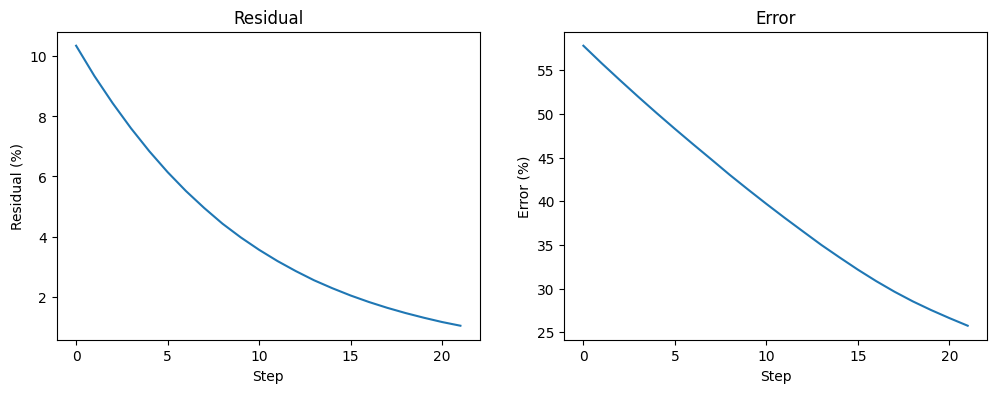

In [54]:
plt.figure(figsize=(12, 4));
"Residual Plot"
plt.subplot(1,2,1)
plt.ylabel('Residual (%)');
plt.xlabel('Step');
plt.title('Residual');
plt.plot(range(0,len(res_vec)), res_vec);

"Error plot"
plt.subplot(1,2,2)
plt.ylabel('Error (%)');
plt.xlabel('Step');
plt.title('Error');
plt.plot(range(0,len(error_vec)), error_vec);
plt.savefig("inverse/graphres", bbox_inches='tight', transparent=True)


#### Summary Data

In [49]:
summary_data=np.vstack((error_vec, res_vec, innerstep_vec, mun_vec))
data=pd.DataFrame(summary_data.T)
experiments=["Error (%)", "Residual (%) ", "Inner Step", "mu_n"]
data.columns = experiments
data

,Error (%),Residual (%),Inner Step,mu_n
0,57.801951,10.354350,0.0,0.000000
1,55.790670,9.345522,36.0,0.900000
2,53.852442,8.438879,35.0,0.900000
3,51.950432,7.604439,35.0,0.899100
4,50.093908,6.840494,35.0,0.898201
5,48.282803,6.145372,35.0,0.897303
6,46.510445,5.516617,35.0,0.896405
7,44.769458,4.950348,35.0,0.895509
8,43.009674,4.427774,36.0,0.894613
9,41.330446,3.970494,35.0,0.896643
